In [ ]:
#Import some packages that we will need
import torch
import matplotlib.pyplot as plt
import pint
import numpy as np
import cv2

u = pint.UnitRegistry()

plt.style.use(['science','notebook'])

%matplotlib ipympl

In [ ]:
#Now let's define our aperture width, our wavelength, and our propagation distance

#Aperture shape
l = 0.1 * u.mm
l_ = 0.5 * u.mm

#Wavelength
wavelength = 660 * u.nm

#Propagation Distance
z = 3 * u.cm

#Wavenumber (k)
wavenumber = 2*np.pi/wavelength

In [ ]:
#1) Find our Fresnel Number
N_f = ( (l/2)**2 ) / (wavelength * z)
N_f = N_f.to_base_units()

if N_f < 0.25:
    print(f"Nf = {N_f.magnitude} - We are in the Far Field")
else:
    print(f"Nf = {N_f.magnitude} - We are in the Near Field")

In [4]:
#2) Choose acceptable aliasing
aliasing_error = 1e-3 #Pretty arbitrary

In [5]:
#3) M, Q, N

#Samples in the open aperture
M = 15

#Sampling Ratio
Q = M / (4*N_f)
Q = Q.to_base_units()

#Total width of the aperture
L = wavelength * z * M / l
L = L.to_compact()

#Total number of samples in the simulation
N = Q * M

#Sample spacing in the aperture plane
dx = L / N
dy = dx
#Sample spacing in the Frequency domain
dfx = 1 / L
dfy = dfx

print(f"M = {M}")
print(f"Q = {Q}")
print(f"N = {N}")
print(f"L = {L}")

M = 15
Q = 29.7 dimensionless
N = 445.5 dimensionless
L = 2.97 millimeter


In [6]:
#4) Create the NxN padded aperture array centered at (N/2, N/2)
# we will embed the open aperture in this array
x = np.linspace((-L/2).magnitude, (L/2).magnitude, int(N.to_base_units().magnitude)) *u.mm
y = x
xx,yy = np.meshgrid(x,y)

#Embed an aperture in the array
U0 = (np.abs(xx) < l / 2) * (np.abs(yy) < l_)
U0 = U0.astype(float)

/home/marshall/miniconda3/envs/sci/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:701: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)


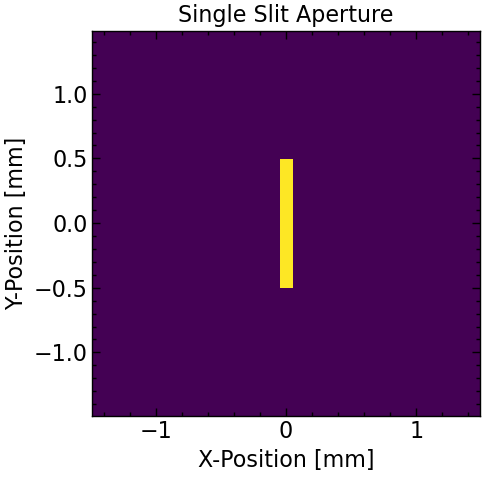

In [7]:
#Plot it to see the aperture
plt.figure(figsize=(5,5))
plt.pcolormesh(xx,yy,U0)
plt.xlabel('X-Position [mm]')
plt.ylabel('Y-Position [mm]')
plt.title("Single Slit Aperture")
plt.show()

In [8]:
#5) Create the quadratic-phase exponential transfer function array 
kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi
ky = kx
kxv, kyv = np.meshgrid(kx,ky)

H = np.exp(1j * wavenumber * z) * np.exp(1j* (z) * np.sqrt(wavenumber**2 - (kxv)**2 - (kyv)**2))
H = np.fft.fftshift(H.magnitude)

In [9]:
#6) Perform the DFT of the aperture and then center
A = np.fft.fft2(U0)
A = np.fft.fftshift(A)

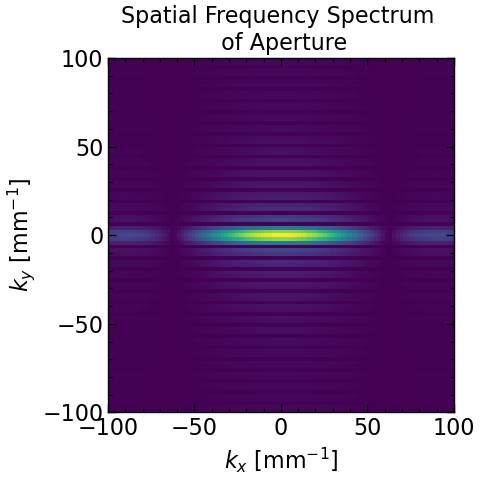

In [10]:
plt.figure(figsize=(5,5))
plt.pcolormesh(np.fft.fftshift(kxv.magnitude), np.fft.fftshift(kyv.magnitude), np.abs(A))
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('$k_x$ [mm$^{-1}$]')
plt.ylabel('$k_y$ [mm$^{-1}$]')
plt.title("Spatial Frequency Spectrum \n of Aperture")
plt.tight_layout()
plt.show()

In [11]:
#7) Multiply
U_ = A * H
U_ = np.fft.ifft2(U_)

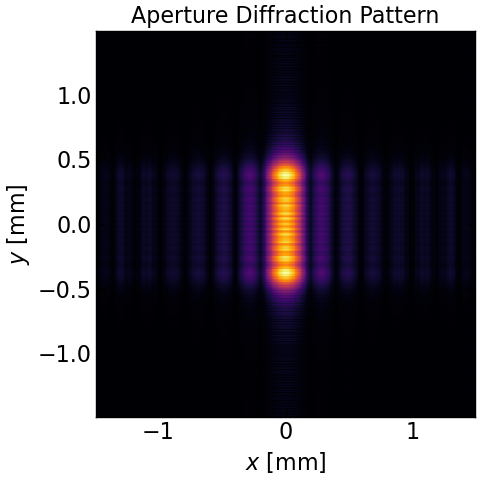

In [12]:
plt.figure(figsize=(5,5))
plt.pcolormesh(xx,yy,np.abs(U_), cmap='inferno')
plt.xlabel('$x$ [mm]')
plt.ylabel('$y$ [mm]')
plt.title("Aperture Diffraction Pattern")
plt.tight_layout()
plt.show()